# Switch / Light example


## system modeling derived from literature

based on TNO report: Guided root analysis of machine failure, par 5.2

a system is an assembly of components + connections between components

how to define a component?
- define inputs and outputs
- define failure modes
- inputs and outputs are associated with modalities and a modality has properties
- relation between inputs and outputs for normal behavior and for every failure mode

how to define an assembly
- components that are part of the assembly
- how the components are connected

limitations/prerequisites system modeling
- every component has one health and one output variable. multiple inputs are possible
- type names are unique
- variable names are unique and follow strict convention PropertyModalityInputsName

### steps to generate influence diagram from a system definition

implementation below uses following steps
- define system
  - define components (inputs/outputs, ...) as dict
  - define connections as dict
  - define system as dict
- create diagram based on system definition
  - generate nodes from dicts and add to influence diagram
  - generate arcs from dict and add to influence diagram
- determine probabilities based on specified normal behavior and failure nodes
- add tests to ID (only tests of health)
- perform diagnosis scenario's
  - inference
  - decide best test

## System specification

### component specification

- a component has a unique name
- every component has one or more inputs, outputs
- every component has one health
- every component has a type
- inputs/outputs/health have modalities which have properties which have values

probabilities
- Health nodes don't have parents, priors can be determined before hand and specified based on experience, data etc. A health node has a state for normal behavior and for every failure mode. The priors are part of the health node specification. 
- A table specifies "normal behavior" via relations between input and output. Since relations in components are deterministic (par 5.2.3) 0 and 1 are used. Note is that the "ALWAYS" and "ELSE" keywords are not yet used in the table.

TODO
- specify failure modes and corresponding prior probability
- add tests per component

In [382]:
# component Switch > Python datastructure dictionary

switch = {
    "type":"Switch",
    "Inputs":{
        "1":{
            "modality":"Power",
            "property":"Present",
            "propertyvalues":["yes", "no"],
            "priorprobability":[0.99,0.01]        },
        "2":
        {
            "modality":"State",
            "property":"Enabled",
            "propertyvalues":["yes", "no"],
            "priorprobability":[0.99,0.01]        }
    },
    "Outputs":{
        "1":{
            "modality":"Power",
            "property":"Present",
            "propertyvalues":["yes", "no"]
        }
    },
    "Healths":{
        "1":{
            "modality":"Health",
            "property":"health",
            "propertyvalues":["ok","broken"],
            "priorprobability":[0.99,0.01]
        }
    },
    "Behavior":{
        "normal": {
            'PresentPowerInputs':  ["yes", "yes","no" , "no"], 
            'EnabledStateInputs':  ["yes", "no" ,"yes", "no"],
            'PresentPowerOutputs': ["yes", "no" ,"no" , "no"],
            'health':              ["ok",  "ok" , "ok", "ok"]
        }
    }
}

In [383]:
# component Light > Python datastructure dictionary

light = {
    "type":"Light",
    "Inputs":{
        "1":{
            "modality":"Power",
            "property":"Present",
            "propertyvalues":["yes", "no"],
            "priorprobability":[0.9,0.1]
        }
    },
    "Outputs":{
        "1":{
            "modality":"Light",
            "property":"Present",
            "propertyvalues":["yes", "no"]
        }
    },
    "Healths":{
        "1":{
            "modality":"Health",
            "property":"health",
            "propertyvalues":["ok","broken"],
            "priorprobability":[0.9,0.1]
        }
    },
    "Behavior":{
        "normal": {
            'PresentPowerInputs':  ["yes", "no"], 
            'PresentLightOutputs': ["yes", "no"],
            'health':              ["ok",  "ok"]
        }
    }

}

### connections connect components 
- connections have a name
- connections have two named components and a direction (start - end)
- connections have a health that is connected to the component that is addressed by the connection
- a table specifies the relation between start and end component states considered normal
- health node has states for OK and for failure states

TODO
- refactor dict with keys: start, end, health, behavior

In [384]:
wire = {
    "type":"Wire",
    "start":"PresentPowerOutputs",
    "typeStart":"Switch",
    "end":"PresentPowerInputs",
    "typeEnd":"Light",
    "Healths":{
        "1":{
            "modality":"Health",
            "property":"health",
            "propertyvalues":["ok","broken"],
            "priorprobability":[0.9,0.1]
        }
    },
    "Behavior":{
        "normal": {
            'PresentPowerInputs' :   ["yes"],
            'PresentPowerOutputs':   ["yes"],
            'health'             :   ["ok"]
        }
    }
}

### system defines assembly
system consists of components and connections between them

In [385]:
structure = {
    "components": {
        "1":{
            "name":"Light",
            "type":"Light"
        },
        "2":{
            "name":"Switch",
            "type":"Switch"           
        }
    },
    "connections":{
        "1":{
            "name":"Wire",
            "type":"Wire",
            "startComponent":"Switch",
            "endComponent":"Light"
        }
    }
}

structure2 = {
    "components": {
        "1":{
            "name":"Light",
            "type":"Light"
        },
        "2":{
            "name":"Switch",
            "type":"Switch"           
        }
    }
}

In [386]:
# create "system"
components = [switch, light]
connections = [wire]
assembly = {
    "components" : components,
    "connections": connections,
    "structure":structure
}

## generate influence diagram structure

In [387]:
# imports
import os
import matplotlib.pyplot as plt
from pylab import *
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

from IPython.display import display,HTML
import re

In [388]:
# purpose: add Components from system structure to diagram

# diag: pyagrum influence diagram
# comp: specification of 1 component
# name: name to use for component in diagram

# result: nodes for 1 component added to diagram

# per modality a variable is generated and added to diagram
# arcs are created to connect inputs to output and health to output

def addComponentToDiagram(diag, comp, name):
    # specifcation contains three relevant sections
    componentkeys = ["Inputs","Outputs","Healths"]
    # get keys in spec component
    keys = comp.keys()
    labels = []
        
    # read inputs, outputs and health specs, add named variable to diagram 
    for ckey in componentkeys:
        if ckey in keys:  
            for modality in comp[ckey].keys():                                             # get modalities
                modalitylabel = comp[ckey][modality]["modality"]                           # get modality label
                property = comp[ckey][modality]["property"]                                # get property label
                propertyvalues = comp[ckey][modality]["propertyvalues"]                    # get property values
                if(ckey == "Healths"):                                                     # shorter name for health
                    label = str(property + name)
                else:
                    label = str(property + modalitylabel + ckey + name)                    # name variable
                labels.append(label)
                diag.addChanceNode(gum.LabelizedVariable(label, label, propertyvalues))    # add variable to diagram

    # add arcs to connect inputs / health nodes to output within component
    inputvars = []
    for label in labels:
        if(re.search("Inputs", label)):
            inputvars.append(diag.idFromName(label))
        if(re.search("health", label)):
            hvar = diag.idFromName(label)
        if(re.search("Outputs",label)):
            ovar = diag.idFromName(label)
            
    # add arc from health node to output
    diag.addArc(hvar, ovar)
    
    # add arc for every input node to output
    for v in inputvars:
        diag.addArc(v,ovar)        

In [389]:
# purpose: read connection specification and connect components in diagram via arc, 
# create health for connection

# diag: pyagrum influence diagram
# name: name to use for connection in diagram
# connection: type of connection used to find right specification for connection
# startComponent: component from which the connection starts
# endComponent: component that receives connection

# result: connection + health for connection created in diagram

def addConnectionToDiagram(diag, name, connection, startComponent, endComponent):
    # get all variable names from diagram
    diaglabels = diag.names()
    
    # match variable with specified start / end component, when found create arc
    for label in diaglabels:
        if(re.search(startComponent, label)):
            if(re.search(connection['start'], label)):
                startvar = diag.idFromName(label)
        elif(re.search(endComponent, label)):
            if(re.search(connection['end'], label)):
                endvar = diag.idFromName(label)
    diag.addArc(startvar, endvar)
    
    # create health node + arc to end component
    label = str("health" + name)
    hvar = diag.addChanceNode(gum.LabelizedVariable(label,label,["ok","broken"]))
    diag.addArc(hvar, endvar)

In [390]:
# find a dict in set of elements (components or connections) by searching for type
def getDictByType(elementType, elementSet):
    found = False
    for c in elementSet:
        if(c["type"] == elementType):
            found = True
            return c
    if(found == False): print("error getDictByType: no dict found for type")

In [391]:
# MAIN method to generate structure
# disassemble system, read systemstructure and add components + connections to diagram
def buildDiagram(diag, assembly):
    # read system
    systemstructure = assembly["structure"]
    components = assembly["components"]
    connections = assembly["connections"]

    # loop sets (connections, components) in assembly structure
    for assemblylist, elements in systemstructure.items():

        # add components from structure to diagram
        if(assemblylist =="components"):
            for n, value in elements.items():
                addComponentToDiagram(diag, getDictByType(value["type"], components) ,value['name'])

        #add connections from structure to diagram
        if(assemblylist =="connections"):
            for n, connection in elements.items():
                connectionType = getDictByType(connection["type"], connections)
                startComponent = connection["startComponent"]
                endComponent = connection["endComponent"]
                connectionName = connection["name"]
                addConnectionToDiagram(diag,connectionName, connectionType, startComponent, endComponent)


## visualize structure

Influence Diagram{
  chance: 8,
  utility: 0,
  decision: 0,
  arcs: 7,
  domainSize: 256
}


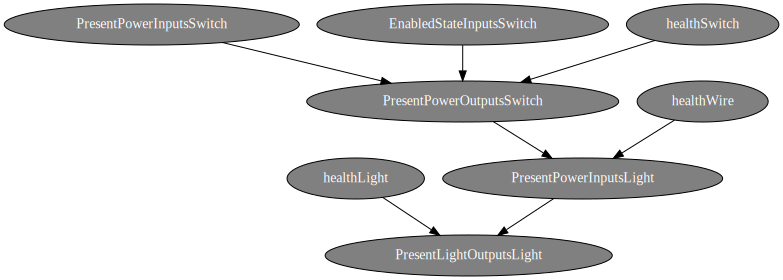

In [392]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# create diagram
diagram = gum.InfluenceDiagram()

# read structure, add to diagram
buildDiagram(diagram, assembly)

# print summary of nodes
print(diagram)

# view structure
gnb.showInfluenceDiagram(diagram, size=60)

## set probabilities

### approach determining probabilities differs per type of node + components vs connections

Health en Inputs
- healths have a normal state and a state for each failure mode, priors can be found in specification since there is no parent
- inputs have "operational" states (PresentPower yes/no), priors can be deterministic and specified via 1 / 0 in the component specification 

Outputs
- the normal state (relations between states of components) is specified as a table in the component specification
- due to deterministic relations 0 and 1 can be used

connecties
- connections are considered a "component" so a table in the connection specification can define "normal behavior and health node can follow guidelines for health of a component 

### implementation

- step 1: per component the priors are determined
  - get all nodeids for nodes of component
  - prior setting differs for inputs, outputs and health
    - health: prior is 1 - sum of failure nodes
    - inputs: prior is 1 for "normal operational state"
      - inputs that have parents are parked for later as they are part of a connection
    - outputs: check all tuples of states in cpt and check if they exsist in normal state relation table
- step 2: next per connection
  - determine involved id's
  - startcomponents should already have priors set and don't need changing
  - for endcomponent read normal behavior relation table from connection specification, follow output method
  - for health follow component health approach
  


In [393]:
import pandas as pd
from deepdiff import DeepDiff

In [394]:
# determine ids in diagram for named component in diagram
def getIdsForName(name):
    ids = []
    for n in diagram.names():
        if (re.search(v["name"], n)):
            ids.append(diagram.idFromName(n))
    return ids

def setCPTHealthNode(i, componentdict, name):
    for k, v in componentdict['Healths'].items():
        id = diagram.idFromName('health' + name)
        diagram.cpt(id).fillWith(v['priorprobability'])
    
    
def setCPTInputsNode(i, componentdict, name):
    for k, v in componentdict['Inputs'].items():
        id = diagram.idFromName(v['property'] + v['modality'] + "Inputs" + name)
        diagram.cpt(id).fillWith(v['priorprobability'])


#         
def renameColumn(dfname, namelist):
    for name in namelist:
        if (re.search(dfname, name)):
            return name    
        
# i: id of variable in diagram: 
# componentdict: dictionary from component type
# namelist: if list contains 1 name it's name of Component, if > 1 names for connections
def setCPTOutputsNode(i, componentdict, namelist):

    # create dataframe based on component normal behavior table
    dfNormalStates = pd.DataFrame.from_dict(data = componentdict['Behavior']['normal'])
    if (len(namelist) == 1):
        # rename columns by adding name of component at the rear
        dfNormalStates.rename(columns=lambda x: x + namelist[0], inplace=True)
    else:
        # match name in list from diagram
        for name in namelist:
            dfNormalStates.rename(columns=lambda x: renameColumn(x, namelist), inplace=True)
    # transform dataframe back to dict but in different format for comparison
    compareDict = dfNormalStates.to_dict('index')


    # CPT has type Potential and contains tuples (Instantiations) of discrete variables
    # loop in CPT, transform tuple to dict
    # if tuple is in normal behavior table: set P(1), else 0
    for tupleVars in diagram.cpt(i).loopIn():
        t1 = tupleVars.todict()
        for k, s in compareDict.items():
            if ('values_changed' not in DeepDiff(s, t1).keys()):
                diagram.cpt(i).set(tupleVars, 1)

def hasParent(diagram, diagId):
    for a in diagram.arcs():
        if (a[1] == diagId): return True
    return False          

In [395]:
# determine probabilities (CPT) for variables of a component

# for every component that is part of the structure
for k, v in assembly["structure"]["components"].items():

    # get id's from diagram for variables that are part of component
    ids = getIdsForName(v["type"])   
    
    # get specification dict for type of component
    typedict = getDictByType(v["type"],assembly["components"])
    
    # for every id validate it's a chancenode, also validate inputs and health don't have parents
    # when inputs have parents it is due to a incoming connection so skip for now
    # determine probability via method for input, output or health
    for i in ids:
        if (diagram.isChanceNode(i)):
            if (re.search("health", diagram.variable(i).name()) and hasParent(diagram, i) == False):
                setCPTHealthNode(i, typedict, v['name'])
            elif (re.search("Inputs", diagram.variable(i).name()) and hasParent(diagram, i) == False):
                setCPTInputsNode(i, typedict, v['name'])
            elif re.search("Outputs", diagram.variable(i).name()):
                setCPTOutputsNode(i, typedict, [v['name']])

In [399]:
# determine probabilities (CPT) for variables of a connection

# loop connections
for k, v in assembly["structure"]["connections"].items():
    
    connName = v['name']
    connType = v['type']
    for e in assembly['connections']:
        if (e['type'] == connType):
            connTypeDict = e
    connStartDiagName = e['start'] + v['startComponent']
    connEndDiagName = e['end'] + v['endComponent']
    idStart = diagram.idFromName(connStartDiagName)
    idEnd = diagram.idFromName(connEndDiagName)
    healthNodeName = "health" + connName
    
setCPTOutputsNode(idEnd, connTypeDict, [connStartDiagName, connEndDiagName, healthNodeName])

setCPTHealthNode(diagram.idFromName(healthNodeName), connTypeDict, connName)

## visualize cpts

In [400]:
gnb.flow.row(diagram.cpt(0),
            diagram.cpt(1),
            diagram.cpt(2),
            diagram.cpt(3),
            captions=[  "prior",
                        "prior",
                        "prior",
                        "prior"
                      ])

In [401]:
gnb.flow.row(diagram.cpt(4),
            diagram.cpt(5),
            diagram.cpt(6),
            diagram.cpt(7),
            captions=[  "prior",
                        "prior",
                        "prior",
                        "prior"
                      ])